In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV,GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
import os
%matplotlib inline
from PIL import Image

In [5]:
#set working directory as project 
os.chdir("C:/Users/athellma/OneDrive - University of North Carolina at Chapel Hill/Documents/Duke University/Research/_HBEF/CameraTrapAnalysis/hbwater_cameratrap_pheno")

## Data Preparation

In [6]:
# Merging Data from files with pixel info of annotated images( after wrangle_VIA_annotation)
w_3 = pd.read_csv("data/training_data/derived/pixels_df_1.csv")
w_6_1= pd.read_csv("data/training_data/derived/pixels_df_2.csv")
w_6_2 = pd.read_csv("data/training_data/derived/pixels_df_3.csv")
# merge watershed folder 6
w_6 = pd.concat([w_6_1, w_6_2]) #this data had the cols [x, y, R, G, B, date, time, orig_name (filename), watershed, temperature, class]

In [7]:
w_6.head()

x     y    R    G    B        date      time  \
0  1403  1265  190  179  219  01/01/2019  11:59:47   
1  1403  1266  190  179  219  01/01/2019  11:59:47   
2  1403  1267  189  178  218  01/01/2019  11:59:47   
3  1403  1268  188  177  217  01/01/2019  11:59:47   
4  1403  1269  189  177  217  01/01/2019  11:59:47   

                       filename watershed temperature   class  
0  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
1  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
2  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
3  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
4  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o

In [8]:
# merge watershed 6 and 3
merged = pd.concat([w_6,w_3])
merged = merged.drop_duplicates()
merged.head()

x     y    R    G    B        date      time  \
0  1403  1265  190  179  219  01/01/2019  11:59:47   
1  1403  1266  190  179  219  01/01/2019  11:59:47   
2  1403  1267  189  178  218  01/01/2019  11:59:47   
3  1403  1268  188  177  217  01/01/2019  11:59:47   
4  1403  1269  189  177  217  01/01/2019  11:59:47   

                       filename watershed temperature   class  
0  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
1  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
2  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
3  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  
4  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o

In [9]:
merged.shape

(11018583, 11)

In [10]:
# create date, time, week of the year, month and season columns to merged dataframe and save
# add year, week of the year, month, and season features to our data
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]
def get_season(now):
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)

merged.date = pd.to_datetime(merged.date)
merged.time = pd.to_datetime(merged.time)
merged["year"] = merged.date.dt.year
merged["week"] =merged.date.dt.isocalendar().week
merged["month"] = merged.date.dt.month
merged["season"] = merged.date.apply(lambda x: get_season(x))
merged = pd.get_dummies(merged, columns=["season"], prefix=["season"] )

C:\Users\athellma\AppData\Local\Temp\ipykernel_25724\1870787921.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged.time = pd.to_datetime(merged.time)


In [11]:
merged.head()

x     y    R    G    B       date                time  \
0  1403  1265  190  179  219 2019-01-01 2024-09-11 11:59:47   
1  1403  1266  190  179  219 2019-01-01 2024-09-11 11:59:47   
2  1403  1267  189  178  218 2019-01-01 2024-09-11 11:59:47   
3  1403  1268  188  177  217 2019-01-01 2024-09-11 11:59:47   
4  1403  1269  189  177  217 2019-01-01 2024-09-11 11:59:47   

                       filename watershed temperature   class  year  week  \
0  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
1  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
2  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
3  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
4  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   

   month  season_autumn  season_spring  season_winter  
0      1          False          False           True  
1      1          False          False           True  
2      1          False          False           True  
3      1          False          False           True  
4      1          False          False           True

In [13]:
# fill missing temperature from previous row
merged.temperature = merged.temperature.ffill()
merged.dropna(inplace=True)

In [14]:
# save csv
merged.to_csv("data/training_data/derived/merged.csv", index=False)

In [15]:
def pick_samples(df):
    '''
    pick samples from each class with defined approximate max class size
    '''
    sampled_df = df.head(1)
    max_class_size = 100
    for date in df.filename.unique(): #change orig_name to filename
        date_grouped = df[df.filename==date] #change orig_name to filename
        nth = len(date_grouped)//max_class_size
        if nth==0:
            sampled_df = pd.concat([sampled_df,date_grouped])
        else:
            curr_group = date_grouped.iloc[::nth,:]
            sampled_df = pd.concat([sampled_df,curr_group])
    sampled_df.drop_duplicates(inplace=True)
    return sampled_df

In [16]:
# make sample data set from merged data
sample_merged = pick_samples(merged)
sample_merged = sample_merged.drop_duplicates()
sample_merged.shape

(20626, 17)

In [17]:
sample_merged.head()

x     y    R    G    B       date                time  \
0    1403  1265  190  179  219 2019-01-01 2024-09-11 11:59:47   
161  1407  1294  187  176  216 2019-01-01 2024-09-11 11:59:47   
322  1412  1290  191  183  222 2019-01-01 2024-09-11 11:59:47   
483  1417  1286  187  181  219 2019-01-01 2024-09-11 11:59:47   
644  1422  1282  185  179  217 2019-01-01 2024-09-11 11:59:47   

                         filename watershed temperature   class  year  week  \
0    Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
161  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
322  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
483  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   
644  Hbwtr_w6_20190101_115947.JPG        w6         35F  snow_o  2019     1   

     month  season_autumn  season_spring  season_winter  
0        1          False          False           True  
161      1          False          False           True  
322      1          False          False           True  
483      1          False          False           True  
644      1          False          False           True

In [39]:
#convert 35F to double 
import re
#re.search(r'\d+', "30F").group()
sample_merged["temp_F"] = sample_merged.apply(lambda row: re.search(r'\d+', row["temperature"]).group(), axis = 1)
sample_merged["temp_F"] = pd.to_numeric(sample_merged["temp_F"])
#re.search(r'\d+', sample_merged["temperature"]).group()

In [36]:
# save sample csv
sample_merged.to_csv("sample_merged.csv", index=False)

In [40]:
sample_merged.describe()

x             y             R             G             B  \
count  20626.000000  20626.000000  20626.000000  20626.000000  20626.000000   
mean    1411.075148   1678.142539    144.034859    131.203093    143.002570   
min      463.000000   1234.000000      0.000000      0.000000      0.000000   
25%     1153.000000   1432.000000     81.000000     61.000000     49.000000   
50%     1382.000000   1582.000000    162.000000    148.000000    168.000000   
75%     1617.000000   1950.000000    201.000000    191.000000    227.000000   
max     2952.000000   2336.000000    255.000000    255.000000    255.000000   
std      350.706702    295.939102     72.628854     74.785195     90.334515   

                                date                           time  \
count                          20626                          20626   
mean   2019-03-28 14:05:19.053621760  2024-09-11 12:00:43.577474816   
min              2018-10-13 00:00:00            2024-09-11 11:58:00   
25%              2018-12-25 00:00:00            2024-09-11 11:59:03   
50%              2019-01-29 00:00:00     2024-09-11 11:59:49.500000   
75%              2019-04-23 00:00:00            2024-09-11 12:01:19   
max              2019-12-30 00:00:00            2024-09-11 12:06:15   
std                              NaN                            NaN   

               year       week         month        temp_F  
count  20626.000000    20626.0  20626.000000  20626.000000  
mean    2018.715941  27.348444      6.777853     33.505818  
min     2018.000000        1.0      1.000000     12.000000  
25%     2018.000000        5.0      2.000000     26.000000  
50%     2019.000000       41.0     10.000000     32.000000  
75%     2019.000000       48.0     12.000000     39.000000  
max     2019.000000       52.0     12.000000     90.000000  
std        0.450976  20.827326      4.773777     11.676093

<Axes: ylabel='class'>

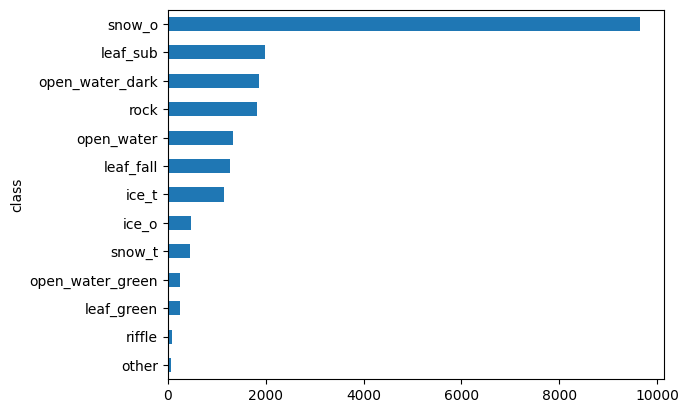

In [23]:
# distribution of classes in sample, indicative of the imbalanced distribution similar in watershed 3 and watershed 6
sample_merged["class"].value_counts().sort_values(ascending=True).plot(kind="barh")

<Axes: ylabel='class'>

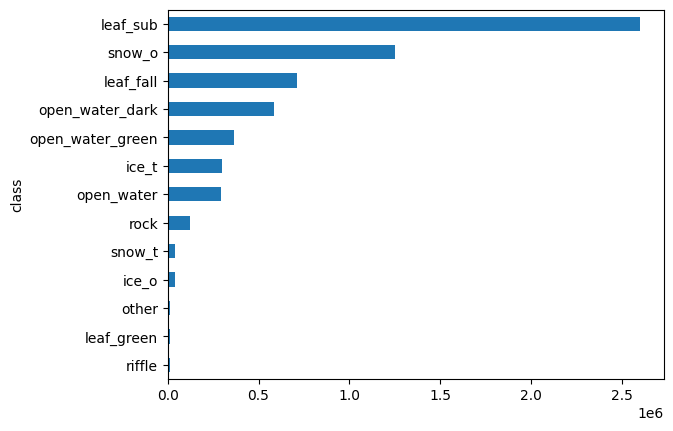

In [24]:
# watershed 6 distribution
w_6["class"].value_counts().sort_values(ascending=True).plot(kind="barh")

<Axes: ylabel='class'>

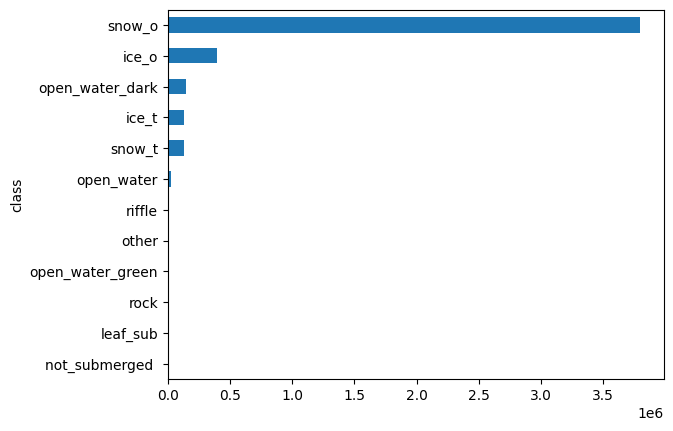

In [22]:
# watershed 3 distribution
w_3["class"].value_counts().sort_values(ascending=True).plot(kind="barh")

Imbalanced class is an issue. But we will train our model keeping the same distribution for now

## Train Random Forest Model

In [25]:
def split_fit_basic_report(df):
    """
    Split dataset into training and test, fit model using mostly default RCF parameters
    return model, prediction, feature_importances, X_train, X_test, y_train, y_test
    
    """
    X = df.drop('class',axis=1)
    y = df['class'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1, stratify=y)
    rfc = RandomForestClassifier(random_state = 1)
    rfc.fit(X_train, y_train)
    # predict on test data
    rfc_pred = rfc.predict(X_test)
    print(classification_report(y_test,rfc_pred))
    feature_val = pd.DataFrame(rfc.feature_importances_, index = X_train.columns)
    print(feature_val.sort_values(0, ascending=False))
    return rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test

def plot_cm(y_test, rfc_pred):
    """
    plot confusion matrix of model predictions
    """
    p,ax = plt.subplots(figsize=(30, 20))

    ConfusionMatrixDisplay.from_predictions(y_test, rfc_pred, ax=ax, colorbar=True)
    plt.show()


### Use features x and y coordinates, RGB values, Temperature

C:\Users\athellma\AppData\Local\Temp\ipykernel_25724\2787038648.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_merged.dropna(inplace=True)


                  precision    recall  f1-score   support

           ice_o       0.80      0.62      0.70       141
           ice_t       0.81      0.79      0.80       345
       leaf_fall       0.85      0.77      0.81       378
      leaf_green       0.96      0.90      0.93        73
        leaf_sub       0.82      0.89      0.85       598
      open_water       0.82      0.80      0.81       400
 open_water_dark       0.88      0.94      0.91       557
open_water_green       0.67      0.60      0.63        73
           other       1.00      0.16      0.27        19
          riffle       0.69      0.39      0.50        23
            rock       0.88      0.93      0.90       547
          snow_o       0.97      1.00      0.99      2895
          snow_t       0.90      0.60      0.72       139

        accuracy                           0.91      6188
       macro avg       0.85      0.72      0.76      6188
    weighted avg       0.91      0.91      0.90      6188

           

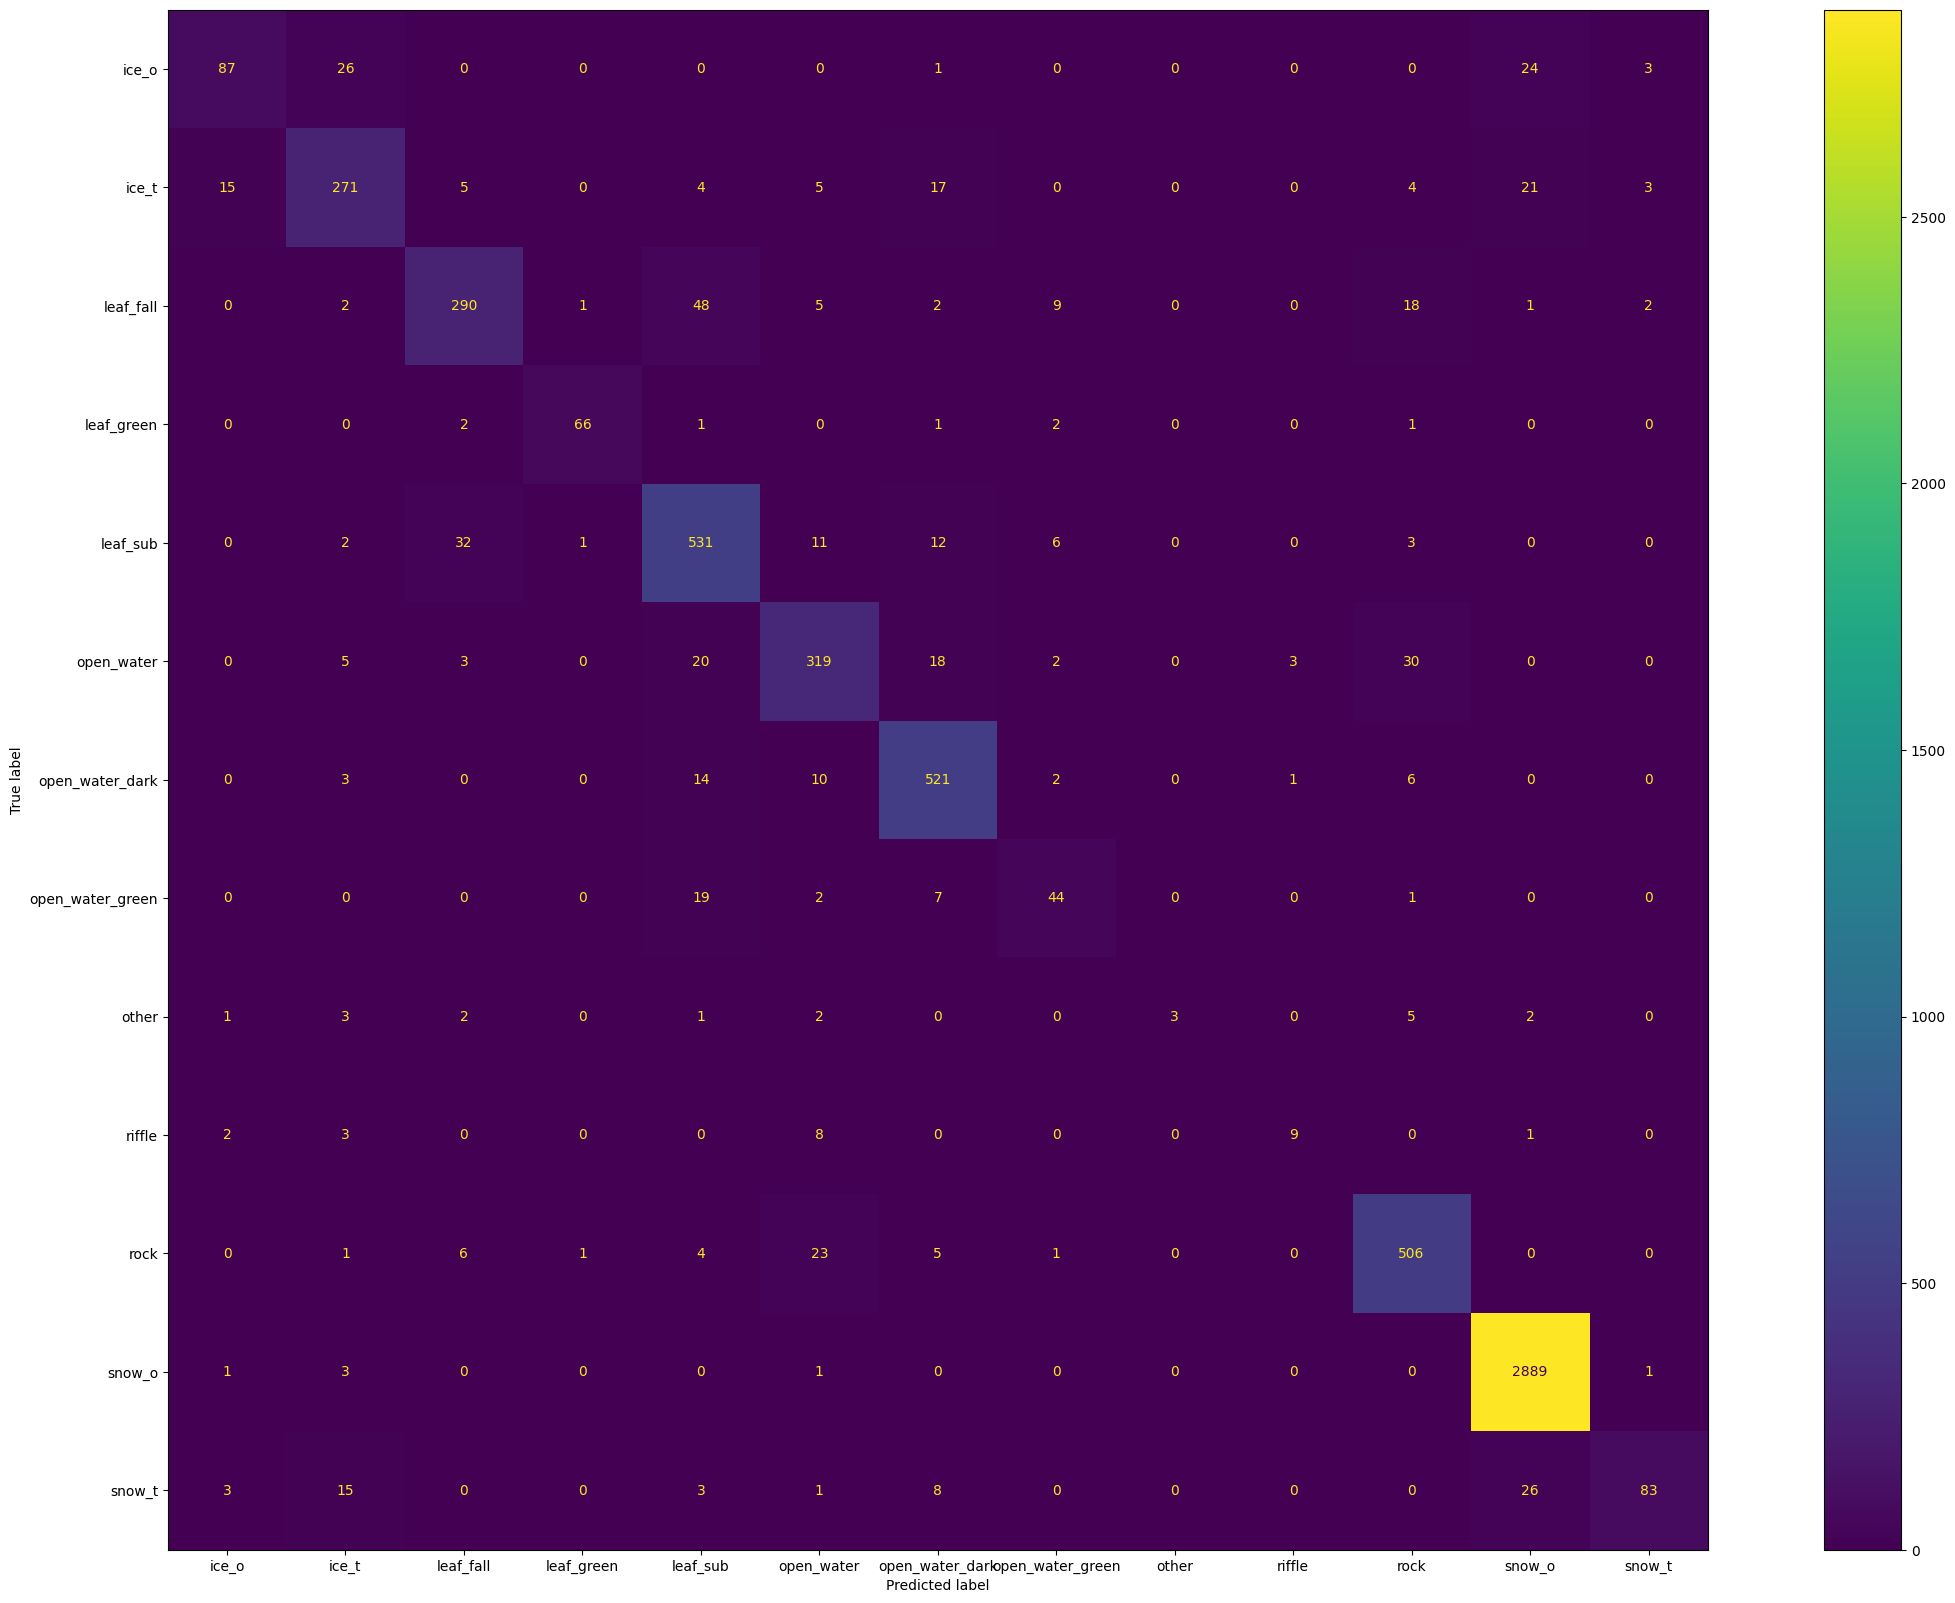

In [41]:
# using x,y,RGB, temp
train_merged = sample_merged[["x","y","R","G","B", "temp_F", "class"]] #changed to numeric temp from temperature 
train_merged.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators for this model and improve predictive performance

In [42]:
## Create Randomized search CV to find estimates closer to the best paramaters
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
n_cpus = os.cpu_count()
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 10, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [43]:
rf_random.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=11,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy')

In [44]:
# best parameters found using random search
rf_random.best_params_

{'n_estimators': np.int64(928),
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'max_depth': 50,
 'criterion': 'entropy',
 'bootstrap': False}

In [45]:
# result of random search cv
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

0.9893337027289099
0.901906916612799


Building up on the results of randomized cv search, find better params using grid search cv


In [47]:
param_grid = {
    'n_estimators': np.linspace(900, 950, 10, dtype = int),
    'max_depth': [30, 40, 50, 60],
    'min_samples_split': [8, 10,12],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)


In [48]:
grid_rf_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [47]:
# best estimators of grid search cv
best_rf_grid = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 8,
 'n_estimators': 950}

In [51]:
# results of grid search cv
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

0.9988947562323468
0.8961318051575932


In [46]:
# feature importances of our input features
pd.DataFrame(best_rf_grid.feature_importances_, index = ["x","y","R","G","B","temperature"], columns=["%_imp"]).sort_values("%_imp", 
                                                                                                                           ascending=False)

NameError: name 'best_rf_grid' is not defined

### Final Model : Use Additional features - Year, Week of day, Season variables

                  precision    recall  f1-score   support

           ice_o       0.97      0.93      0.95       191
           ice_t       0.91      0.92      0.92       516
       leaf_fall       0.94      0.91      0.92       365
      leaf_green       0.96      0.95      0.95        77
        leaf_sub       0.90      0.95      0.92       577
      open_water       0.92      0.92      0.92       412
 open_water_dark       0.93      0.96      0.95      1250
open_water_green       0.92      0.83      0.88       421
           other       1.00      0.35      0.52        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      1.00      2383
          snow_t       0.97      0.88      0.92       133

        accuracy                           0.95      6980
       macro avg       0.95      0.88      0.90      6980
    weighted avg       0.95      0.95      0.95      6980

           

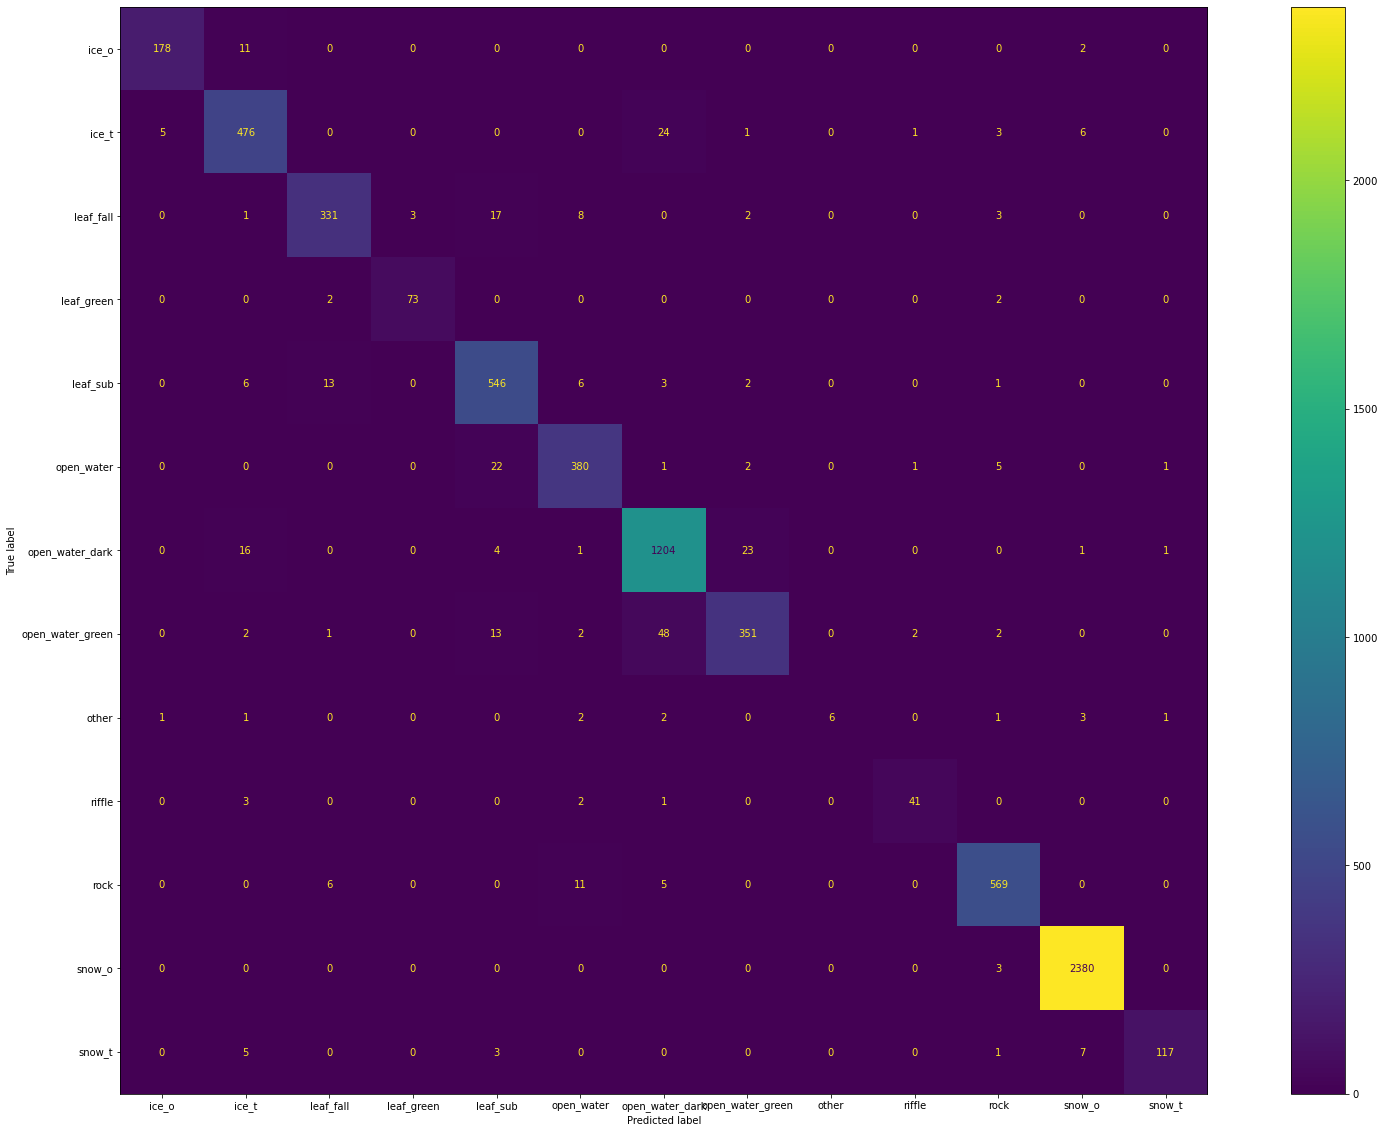

In [11]:
# model using RF default parameters
train_merged_2 = sample_merged[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'class', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']]
train_merged_2.dropna(inplace=True)
rfc, rfc_pred,feature_val,  X_train, X_test, y_train, y_test = split_fit_basic_report(train_merged_2)
plot_cm(y_test, rfc_pred)

Use grid search to select best estimators and improve accuracy

In [12]:
# grid search create dict
# Number of trees in random forest
n_estimators = np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int)
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [1, 5, 10, 20, 50, 75, 100, 150, 200]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 20, 30]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Criterion
criterion=['gini', 'entropy']
random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'criterion': criterion}
rf_base = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf_base,
                               param_distributions = random_grid,
                               n_iter = 20, cv = 5,
                               random_state=42, n_jobs = n_cpus-1,
                               scoring = "accuracy")

In [80]:
rf_random.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.901 total time=   9.7s
[CV 3/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 4/5] END bootstrap=True, criterion=entropy, max_depth=75, min_samples_leaf=2, min_samples_split=20, n_estimators=307;, score=0.905 total time=   9.4s
[CV 2/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.912 total time= 1.3min
[CV 2/5] END bootstrap=True, criterion=entropy, max_depth=20, min_samples_leaf=2, min_samples_split=5, n_estimators=307;, score=0.931 total time=   9.5s
[CV 5/5] END bootstrap=False, criterion=entropy, max_depth=100, min_samples_leaf=1, min_samples_split=30, n_estimators=1964;, score=0.906 total time= 1.3min
[CV 1/

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=20,
                   n_jobs=63,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 5, 10, 20, 50, 75, 100,
                                                      150, 200],
                                        'min_samples_leaf': [1, 2, 3, 4],
                                        'min_samples_split': [2, 5, 10, 15, 20,
                                                              30],
                                        'n_estimators': array([ 100,  307,  514,  721,  928, 1135, 1342, 1550, 1757, 1964, 2171,
       2378, 2585, 2792, 3000])},
                   random_state=42, scoring='accuracy', verbose=3)

In [82]:
rf_random.best_params_

{'n_estimators': 2378,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_depth': 75,
 'criterion': 'entropy',
 'bootstrap': False}

In [ ]:
# training error
print (rf_random.score(X_train, y_train))
# testing error
print(rf_random.score(X_test, y_test))

In [13]:
# build up on the randomized cv search and find better params
param_grid = {
    'n_estimators': np.linspace(2300, 2400, 10, dtype = int),
    'max_depth': [30, 55, 75],
    'min_samples_split': [4,5],
    'min_samples_leaf': [1, 2]
}
# Base model
rf_grid = RandomForestClassifier(criterion = 'entropy', bootstrap = False)
# Instantiate the grid search model
grid_rf_search = GridSearchCV(estimator = rf_grid, param_grid = param_grid, 
                          cv = 5, n_jobs = n_cpus-1)

In [14]:
grid_rf_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(bootstrap=False,
                                              criterion='entropy'),
             n_jobs=63,
             param_grid={'max_depth': [30, 55, 75], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [4, 5],
                         'n_estimators': array([2300, 2311, 2322, 2333, 2344, 2355, 2366, 2377, 2388, 2400])})

In [118]:
best_rf_grid_final = grid_rf_search.best_estimator_
grid_rf_search.best_params_

{'max_depth': 30,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 2355}

In [17]:
# training error
print (grid_rf_search.score(X_train, y_train))
# testing error
print(grid_rf_search.score(X_test, y_test))

1.0
0.9594555873925501


In [119]:
pd.DataFrame(best_rf_grid_final.feature_importances_, index = X_train.columns, columns=["%_imp"]).sort_values("%_imp",ascending=False)

%_imp
B              0.212463
G              0.118422
R              0.116707
week           0.110567
y              0.102641
x              0.071066
year           0.071063
temperature    0.068147
month          0.062842
season_winter  0.037524
season_autumn  0.017280
season_spring  0.011278

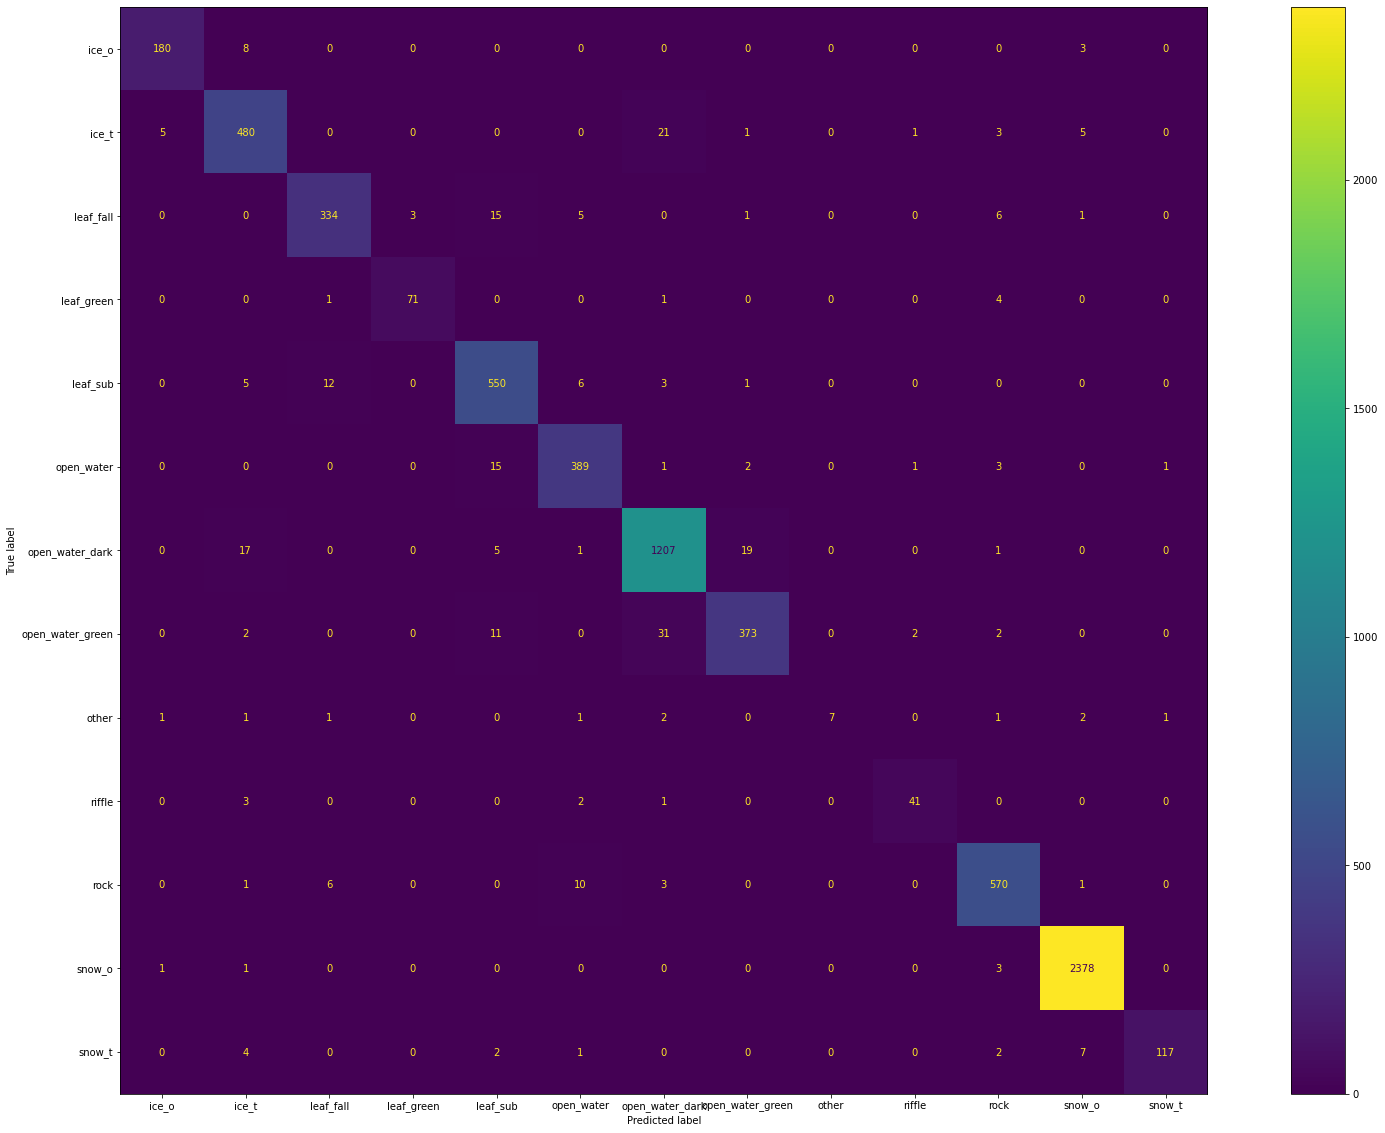

In [45]:
rf_pred = best_rf_grid_2.predict(X_test)
plot_cm(y_test, rf_pred)

In [46]:
print(classification_report(y_test,rf_pred))

                  precision    recall  f1-score   support

           ice_o       0.96      0.94      0.95       191
           ice_t       0.92      0.93      0.92       516
       leaf_fall       0.94      0.92      0.93       365
      leaf_green       0.96      0.92      0.94        77
        leaf_sub       0.92      0.95      0.94       577
      open_water       0.94      0.94      0.94       412
 open_water_dark       0.95      0.97      0.96      1250
open_water_green       0.94      0.89      0.91       421
           other       1.00      0.41      0.58        17
          riffle       0.91      0.87      0.89        47
            rock       0.96      0.96      0.96       591
          snow_o       0.99      1.00      0.99      2383
          snow_t       0.98      0.88      0.93       133

        accuracy                           0.96      6980
       macro avg       0.95      0.89      0.91      6980
    weighted avg       0.96      0.96      0.96      6980



Final Model:
- accuracy of 96% 
- weighted average recall of 96%

In [36]:
# save final model
from joblib import dump, load
dump(best_rf_grid_final, "model.joblib")
# model= load("model.joblib")

In [1]:
from joblib import dump, load

model= load("model.joblib")

In [2]:
dump(model, "model_cop.joblib", compress=9)

['model_cop.joblib']

### Test Model on Unseen Data
- We will use a new data sample which was not used for model training and model testing

In [30]:
# data points that are not in sampled data
ind_array = np.setdiff1d(merged.index,sample_merged.index)

In [41]:
# create test sample data from data points unused for model trainnig and model testing
test_sample = pick_samples(merged.loc[ind_array])

In [42]:
test_sample.describe()

x             y             R             G             B  \
count  34173.000000  34173.000000  34173.000000  34173.000000  34173.000000   
mean    1229.538788   1729.130512    131.752261    121.442864    128.541509   
std      376.883822    327.228595     78.485869     79.734538     93.283229   
min       47.000000   1235.000000      0.000000      0.000000      0.000000   
25%     1037.000000   1439.000000     59.000000     47.000000     38.000000   
50%     1268.000000   1608.000000    125.000000    111.000000    105.000000   
75%     1489.000000   2074.000000    202.000000    194.000000    230.000000   
max     1997.000000   2337.000000    255.000000    255.000000    255.000000   

        temperature         year          week         month  season_autumn  \
count  34173.000000  34173.00000  34173.000000  34173.000000   34173.000000   
mean      36.054575   2018.98215     24.477863      6.108185       0.367337   
std       12.327823      0.67875     19.982345      4.593180       0.482086   
min       12.000000   2018.00000      1.000000      1.000000       0.000000   
25%       28.000000   2019.00000      6.000000      2.000000       0.000000   
50%       33.000000   2019.00000     13.000000      4.000000       0.000000   
75%       43.000000   2019.00000     47.000000     11.000000       1.000000   
max       98.000000   2020.00000     52.000000     12.000000       1.000000   

       season_spring  season_winter  
count   34173.000000   34173.000000  
mean        0.106575       0.526088  
std         0.308577       0.499326  
min         0.000000       0.000000  
25%         0.000000       0.000000  
50%         0.000000       1.000000  
75%         0.000000       1.000000  
max         1.000000       1.000000

In [43]:
test_sample.head()

x     y    R    G    B       date                time  \
1    1403  1266  192  177  218 2019-01-01 2022-07-19 11:59:47   
162  1407  1295  186  175  215 2019-01-01 2022-07-19 11:59:47   
323  1412  1291  194  183  223 2019-01-01 2022-07-19 11:59:47   
484  1417  1287  187  179  218 2019-01-01 2022-07-19 11:59:47   
645  1422  1283  185  179  217 2019-01-01 2022-07-19 11:59:47   

                        orig_name watershed  temperature   class  year  week  \
1    Hbwtr_w6_20190101_115947.JPG        w6         35.0  snow_o  2019     1   
162  Hbwtr_w6_20190101_115947.JPG        w6         35.0  snow_o  2019     1   
323  Hbwtr_w6_20190101_115947.JPG        w6         35.0  snow_o  2019     1   
484  Hbwtr_w6_20190101_115947.JPG        w6         35.0  snow_o  2019     1   
645  Hbwtr_w6_20190101_115947.JPG        w6         35.0  snow_o  2019     1   

     month  season_autumn  season_spring  season_winter  
1        1              0              0              1  
162      1              0              0              1  
323      1              0              0              1  
484      1              0              0              1  
645      1              0              0              1

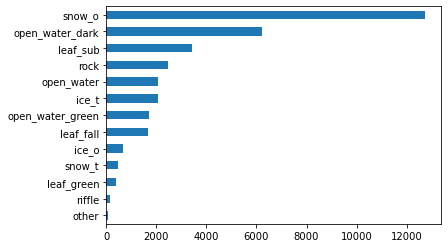

In [47]:
# expected similar distribution of class
test_sample["class"].value_counts().sort_values(ascending=True).plot(kind="barh");

In [49]:
# subset data with desired features/ columns
test_sample = test_sample[
    ['x', 'y', 'R', 'G', 'B',  'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter',"class"]]
# split data to features and labels
test_sample_features=test_sample.drop("class", axis=1)
test_sample_labels =test_sample["class"]

In [28]:
# predict result of sample test data with our model
sample_predict = model.predict(test_sample_features)

In [ ]:
# evaluate prediction result
print(classification_report(test_sample_labels,sample_predict))

                  precision    recall  f1-score   support

           ice_o       0.99      0.98      0.99       636
           ice_t       0.98      0.98      0.98      1702
       leaf_fall       0.98      0.97      0.98      1217
      leaf_green       0.99      0.98      0.98       256
        leaf_sub       0.98      0.99      0.98      1922
      open_water       0.98      0.98      0.98      1372
 open_water_dark       0.98      0.99      0.99      4098
open_water_green       0.98      0.97      0.97      1405
           other       1.00      0.83      0.91        58
          riffle       0.97      0.96      0.97       158
            rock       0.99      0.99      0.99      1969
          snow_o       1.00      1.00      1.00      7829
          snow_t       1.00      0.96      0.98       442

        accuracy                           0.99     23064
       macro avg       0.99      0.97      0.98     23064
    weighted avg       0.99      0.99      0.99     23064



Result of model on unseen new data sample:

- Accuracy: 99%
- Average Recall: 99%

# Visualizing the result of our model's prediction

In [ ]:
pip install colordict

In [56]:
# use this module to get rgb values of colors
from colordict import ColorDict
colors = ColorDict()

In [37]:
# dictionary of class to color
class_rgb = {'snow_o': "white",
 'open_water_dark': "gray",
 'ice_t': "brown",
 'rock': "orange",
 'leaf_fall': "red",
 'snow_t': "blueviolet",
 'leaf_sub': "green",
 'other': "pink",
 'ice_o': "darkgrey",
 'leaf_green': "gold",
 'open_water': "indigo",
 'riffle': "magenta",
 'open_water_green': "rose"}

In [38]:
# updated dictionary
class_rgb = {'snow_o': "white",
'open_water_dark': "royalblue",
'ice_t': "gray",
'rock': "purple",
'leaf_fall': "orange",
'snow_t': "blueviolet",
'leaf_sub': "goldenrod",
'other': "pink",
'ice_o': "darkgrey",
'leaf_green': "forestgreen",
'open_water': "indigo",
'riffle': "magenta",
'open_water_green': "rose"}

In [46]:
# desired column list
li = ['x', 'y', 'R', 'G', 'B', 'temperature', 'year', 'week', 'month',
       'season_autumn', 'season_spring', 'season_winter']
def display_predict_img(file):
    img= np.asarray(Image.open("invert_"+file))
    img_cp = img.copy()
    ind =np.where((img[:,:,0]!=0) & (img[:,:,1]!=0) & (img[:,:,2]!=0))
    y_vals = ind[0]
    x_vals = ind[1]
    _= img[y_vals,x_vals,:]
    r_vals, g_vals, b_vals = _[:,0], _[:,1], _[:,2]
    fl = merged[merged.orig_name==file][li] #change orig_name to filename
    point = pd.DataFrame({'x': x_vals,
     'y': y_vals,
     'R': r_vals,
     'G': g_vals,
     'B': b_vals,
    })
    point['temperature']= fl.temperature.values[0]
    point['year']= fl.year.values[0]
    point['week']= fl.week.values[0]
    point['month']= fl.month.values[0]
    point['season_autumn']= fl.season_autumn.values[0]
    point['season_spring']= fl.season_spring.values[0]
    point['season_winter']= fl.season_winter.values[0]
    
    pr = model.predict(point)
    point["pred_class"] = pr
    def apply_change(row):
        pred = row["pred_class"]
        newR, newG, newB=colors[class_rgb[pred]]
        img_cp[row.y,row.x,:] = [newR, newG,newB]
    point.apply(lambda x: apply_change(x), axis=1)
    f, ax = plt.subplots(1,2)
    ax[0].imshow(img)
    ax[1].imshow(img_cp)
    f.set_figheight(15)
    f.set_figwidth(15)

    return img, img_cp, point

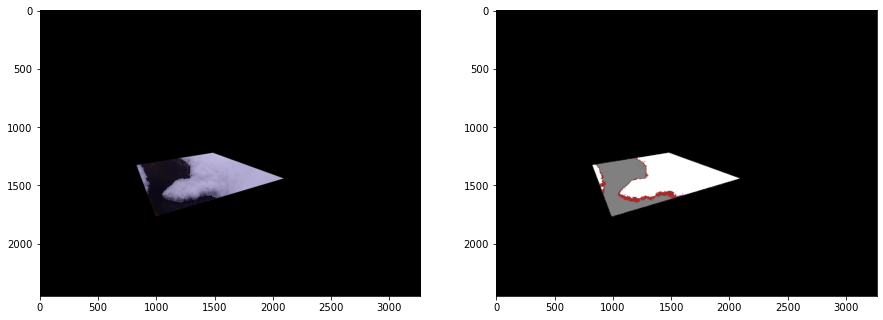

In [66]:
img, img_cp, point= display_predict_img("Hbwtr_w6_20190101_115947.JPG")

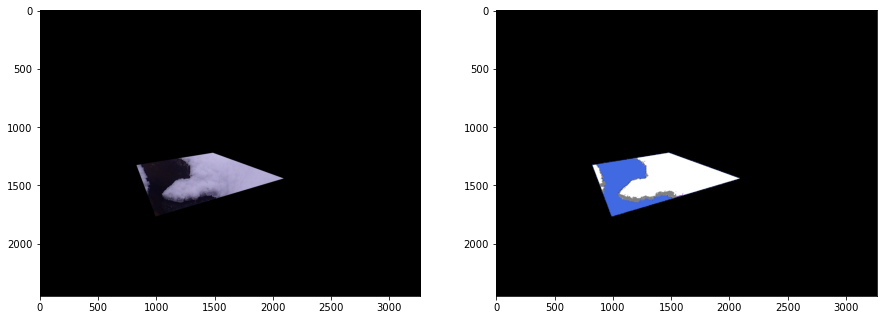

In [68]:
# modified color map
img, img_cp, point= display_predict_img("Hbwtr_w6_20190101_115947.JPG")

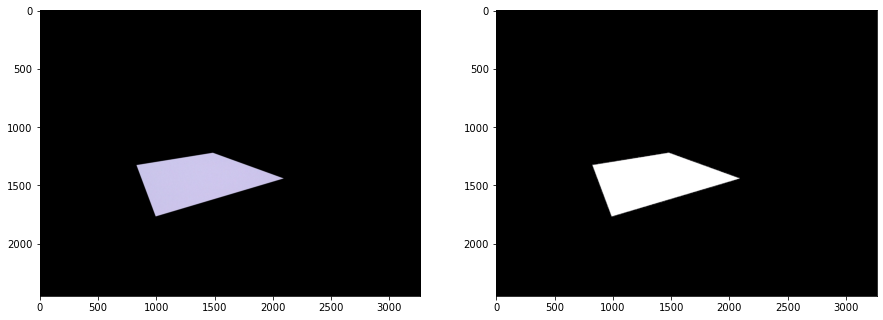

In [154]:
img_2_2, img_cp_2, point_2= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

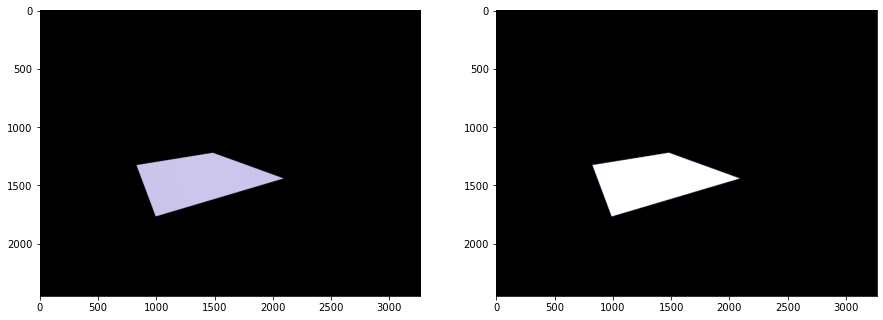

In [69]:
# modified color map
img_2_2, img_cp_2, point_2= display_predict_img("Hbwtr_w6_20190224_120101.JPG")

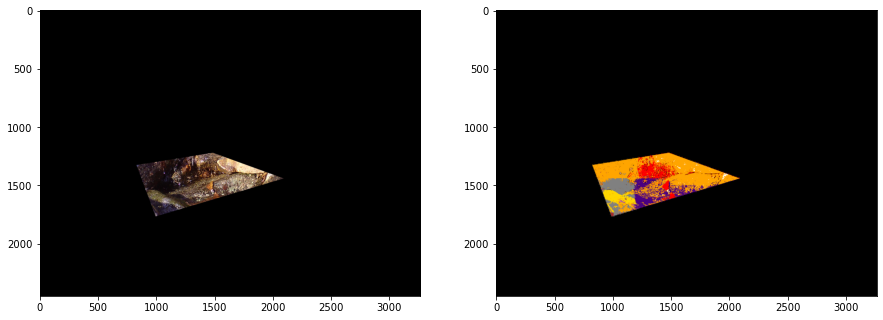

In [189]:
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191211_115931.JPG")

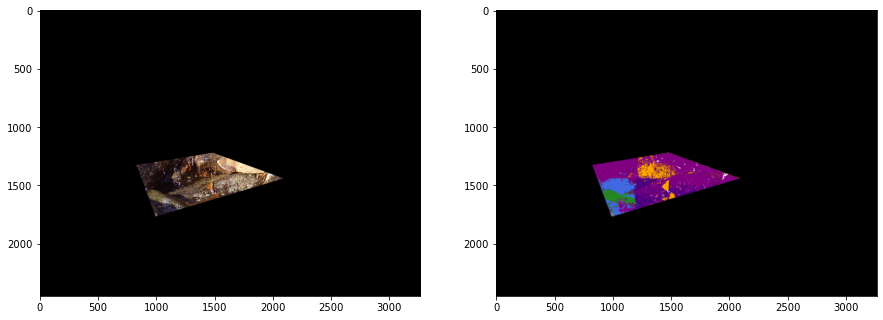

In [70]:
# modified color map
img_2_4, img_cp_4, point_4= display_predict_img("Hbwtr_w6_20191211_115931.JPG")

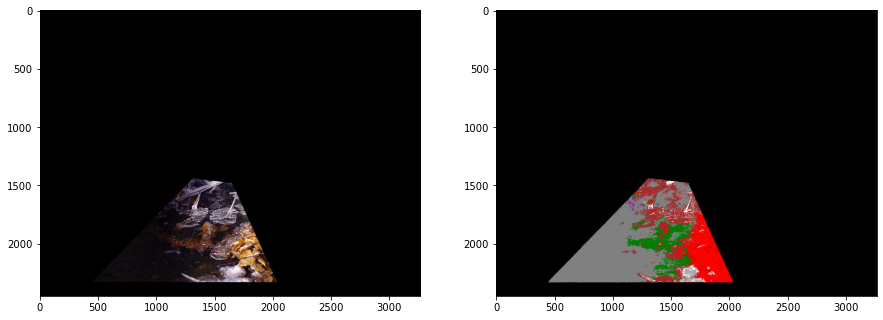

In [192]:
img_2_5, img_cp_5, point_5= display_predict_img("Hbwtr_w6_20181205_115912.JPG")

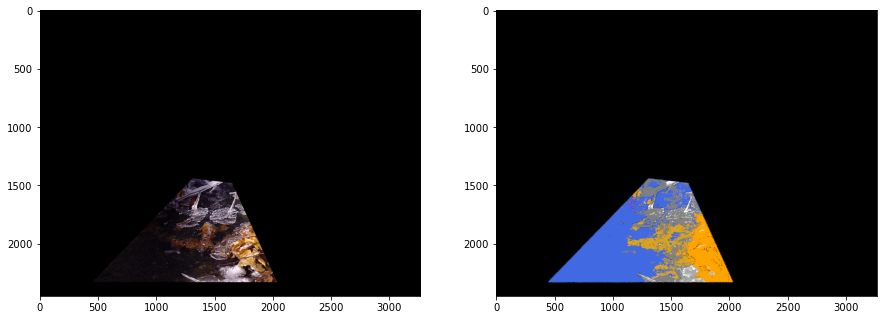

In [ ]:
# modified color map
img_2_5, img_cp_5, point_5= display_predict_img("Hbwtr_w6_20181205_115912.JPG")

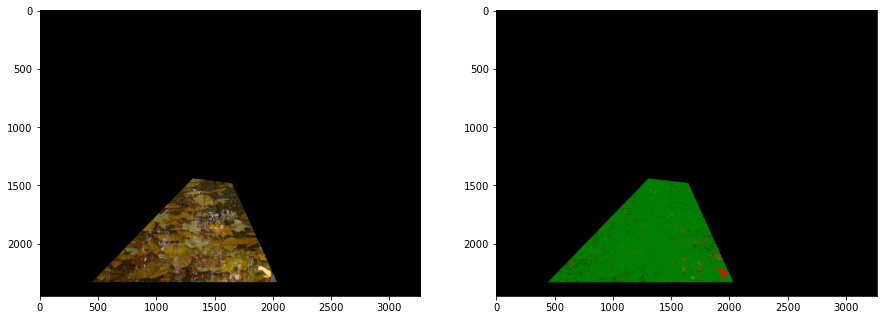

In [ ]:
img_2_6, img_cp_6, point_6= display_predict_img("Hbwtr_w6_20181031_115902.JPG")

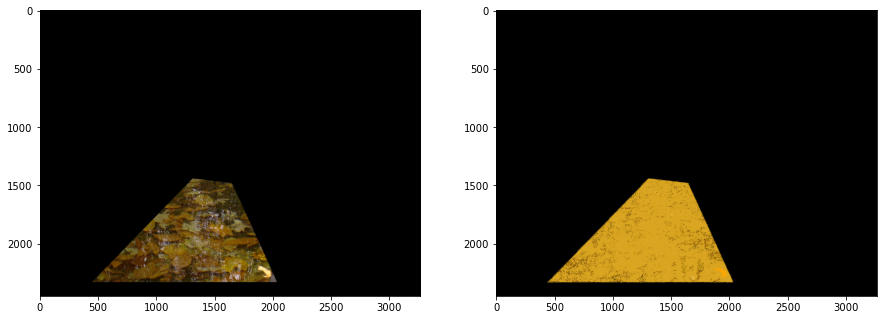

In [72]:
# modified color map
img_2_6, img_cp_6, point_6= display_predict_img("Hbwtr_w6_20181031_115902.JPG")

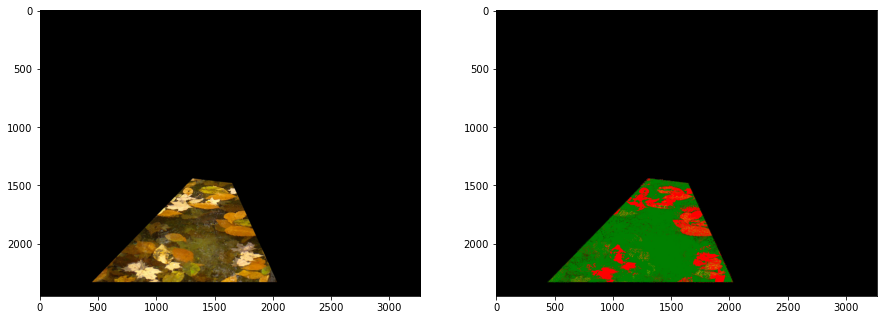

In [195]:
img_2_7, img_cp_7, point_7= display_predict_img("Hbwtr_w6_20181023_115928.JPG")

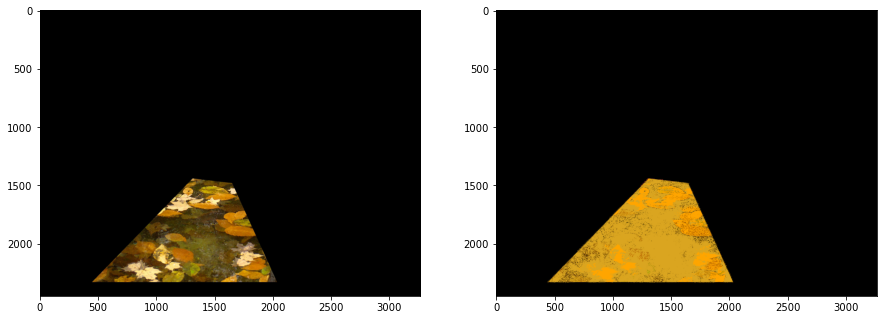

In [73]:
# modified color map
img_2_7, img_cp_7, point_7= display_predict_img("Hbwtr_w6_20181023_115928.JPG")

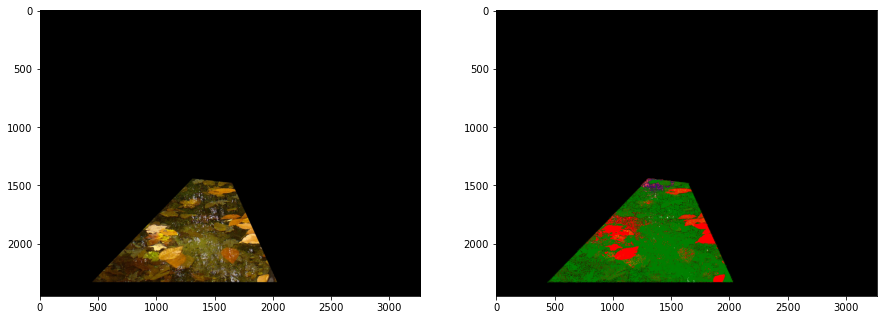

In [196]:
img_2_8, img_cp_8, point_8= display_predict_img("Hbwtr_w6_20181021_115934.JPG")

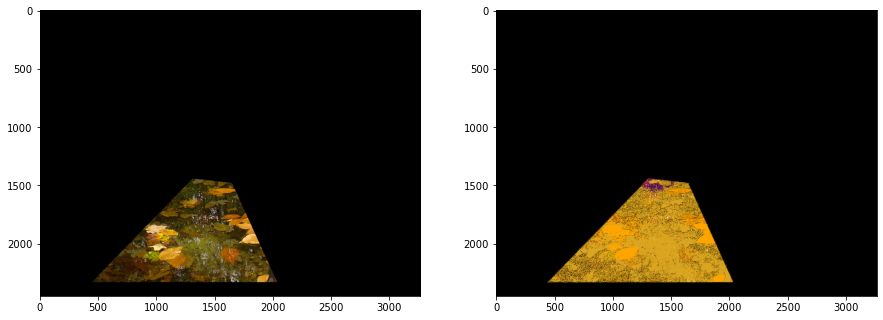

In [74]:
# modified color map
img_2_8, img_cp_8, point_8= display_predict_img("Hbwtr_w6_20181021_115934.JPG")